### El aprendizaje automático:

El aprendizaje automático es un subconjunto de la inteligencia artificial que proporciona a una máquina la capacidad de aprender automáticamente a partir de la experiencia sin ser programada explícitamente.

### Observations:

     Al final del kernel, puede encontrar las métricas de evaluación donde encuentra que la métrica AUC no es buena para ninguno de los algoritmos que se prueban
- La precisión de algunos modelos resultó ser del 100 %, mientras que la precesión, la recuperación y la puntuación F1 no son satisfactorias
- La parte desafiante de este conjunto de datos es limpiar los datos sin procesar.

### Nota:
- una de las posibles razones por las que los modelos no funcionan bien es por el tamaño muy pequeño del conjunto de datos.
    
    

In [33]:
# Importamos las bibliotecas para la carga y el preprocesamiento de datos. 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix

In [34]:
project_data = pd.read_csv("../input/transport/transport.csv")

In [35]:
project_data.head()

,num;age;sexe;sitfam;principal;voiture;velo;commun;revenu
0,1;25;H;1;1;0;1;0;1200
1,2;29;F;1;3;1;0;1;1330
2,3;35;F;3;1;1;0;0;1850
3,4;19;F;2;4;0;0;1;
4,5;23;H;5;2;;;;2560


In [36]:
# nuevo marco de datos con columnas de valores divididos
new = project_data["num;age;sexe;sitfam;principal;voiture;velo;commun;revenu"].str.split(";", n = 9, expand = True)
 
# hacer una columna separada del nuevo marco de datos
project_data["num"]= pd.to_numeric(new[0])
project_data["age"]= pd.to_numeric(new[1])
project_data["sexe"]= new[2].astype(str)
project_data["sitfam"]= pd.to_numeric(new[3])
project_data["principal"]= pd.to_numeric(new[4])
project_data["voiture"]= pd.to_numeric(new[5])
project_data["velo"]= pd.to_numeric(new[6])
project_data["commun"]= pd.to_numeric(new[7])
project_data["revenu"]= pd.to_numeric(new[8])
 
# Eliminando columnas antiguas
project_data.drop(columns =["num;age;sexe;sitfam;principal;voiture;velo;commun;revenu"], inplace = True)

In [37]:
project_data.columns

Index(['num', 'age', 'sexe', 'sitfam', 'principal', 'voiture', 'velo',
       'commun', 'revenu'],
      dtype='object')

In [38]:
#Comprobamos nuevamente el orden de las columnas 
project_data.head()

,num,age,sexe,sitfam,principal,voiture,velo,commun,revenu
0,1,25,H,1,1,0.0,1.0,0.0,1200.0
1,2,29,F,1,3,1.0,0.0,1.0,1330.0
2,3,35,F,3,1,1.0,0.0,0.0,1850.0
3,4,19,F,2,4,0.0,0.0,1.0,NaN
4,5,23,H,5,2,NaN,NaN,NaN,2560.0


In [39]:
#Revisamos las estadísticas de las variables numéricas con el método de descripción. 
#Si usamos la transposición del conjunto de datos, puede ver mejor las estadísticas.
project_data.describe()

,num,age,sitfam,principal,voiture,velo,commun,revenu
count,50.00000,50.000000,50.00000,50.000000,46.000000,46.000000,46.000000,47.000000
mean,25.50000,31.980000,3.00000,1.920000,0.586957,0.347826,0.478261,1756.170213
std,14.57738,9.190701,2.10926,1.103612,0.497821,0.481543,0.505047,564.390988
min,1.00000,19.000000,1.00000,1.000000,0.000000,0.000000,0.000000,900.000000
25%,13.25000,23.250000,2.00000,1.000000,0.000000,0.000000,0.000000,1325.000000
50%,25.50000,32.500000,3.00000,1.000000,1.000000,0.000000,0.000000,1600.000000
75%,37.75000,38.000000,3.00000,3.000000,1.000000,1.000000,1.000000,2155.000000
max,50.00000,48.000000,9.00000,4.000000,1.000000,1.000000,1.000000,3200.000000


In [40]:
#usaré el método de información para obtener más información sobre el conjunto de datos.
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   num        50 non-null     int64  
 1   age        50 non-null     int64  
 2   sexe       50 non-null     object 
 3   sitfam     50 non-null     int64  
 4   principal  50 non-null     int64  
 5   voiture    46 non-null     float64
 6   velo       46 non-null     float64
 7   commun     46 non-null     float64
 8   revenu     47 non-null     float64
dtypes: float64(4), int64(4), object(1)
memory usage: 3.6+ KB


In [41]:
#devuelve el número de valores NaN en todas las columnas 
project_data.isna().sum()

num          0
age          0
sexe         0
sitfam       0
principal    0
voiture      4
velo         4
commun       4
revenu       3
dtype: int64

In [42]:
### Preprocesamiento de datos:

In [43]:
#La función sklearn.preprocessing.LabelEncoder codifica etiquetas de una característica categórica
#en valores numéricos entre 0 y el número de clases menos 1. Una vez instanciado, el método fit lo 
#entrena (creando el mapeado entre las etiquetas y los números) y el método transform transforma 
#las etiquetas que se incluyan como argumento en los números correspondientes. 
#El método fit_transform realiza ambas acciones simultáneamente.
encoder = LabelEncoder()
project_data["sexe"] = encoder.fit_transform(project_data["sexe"])

In [44]:
#so este método para completar los valores faltantes por promedio de una columna.
project_data = project_data.apply(lambda x: x.fillna(x.median()),axis=0)

## Análisis univariado y bivariado

<Figure size 864x576 with 0 Axes>

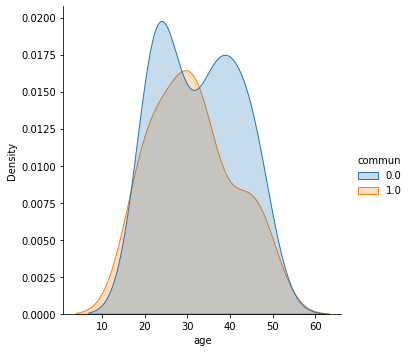

In [45]:
#Descripción: La grafica muestra la densidad en el eje y la edad en el eje x según de la variable común Si el individuo toma el transporte público o no
plt.figure(figsize=(12,8))
sns.displot(data=project_data, x="age", hue="commun", kind="kde", fill=True)

<Figure size 864x576 with 0 Axes>

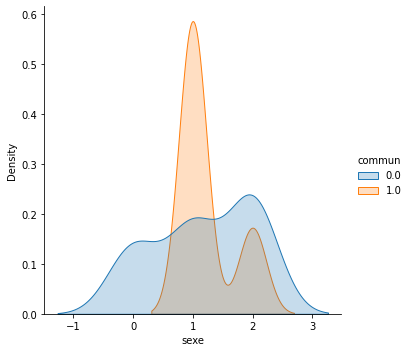

In [46]:
#Descripción: Toma de transporte según el sexo
plt.figure(figsize=(12,8))
sns.displot(data=project_data, x="sexe", hue="commun", kind="kde", fill=True)

<Figure size 864x576 with 0 Axes>

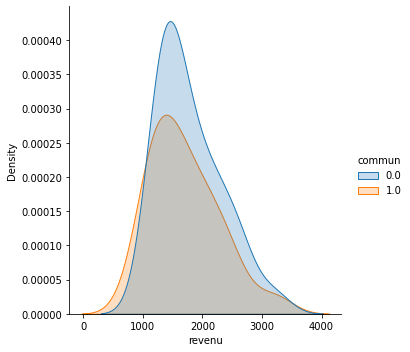

In [47]:
#Descripción: Toma de transporte según el nivel de ingresos, cuando aumenta la variable ingresos, tanto los ciudadanos usan más el sistema de transporte. 
plt.figure(figsize=(12,8))
sns.displot(data=project_data, x="revenu", hue="commun", kind="kde", fill=True)

<Figure size 864x576 with 0 Axes>

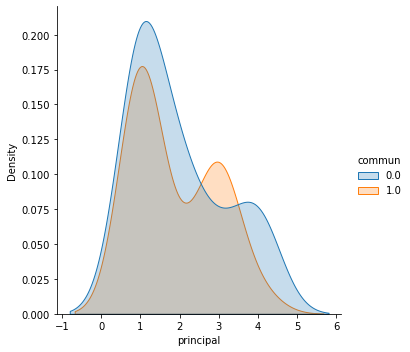

In [48]:
#grafica principales medios de transporte
plt.figure(figsize=(12,8))
sns.displot(data=project_data, x="principal", hue="commun", kind="kde", fill=True)

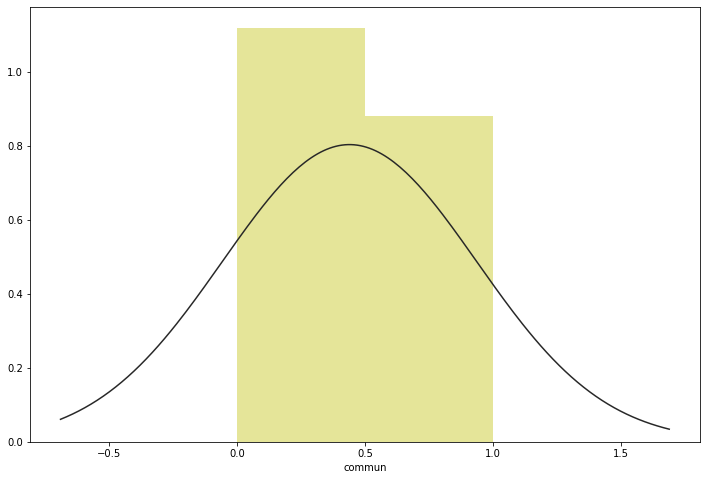

In [49]:
plt.figure(figsize=(12,8))
chart = sns.distplot(project_data["commun"], fit=norm, kde=False, color='y')

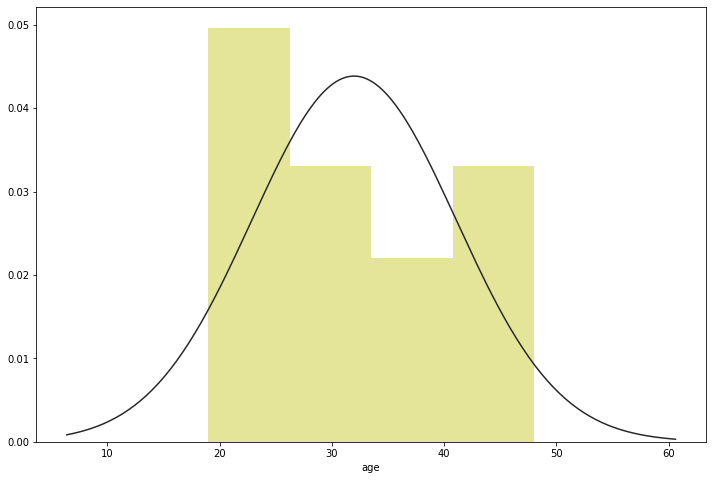

In [50]:
plt.figure(figsize=(12,8))
chart = sns.distplot(project_data["age"], fit=norm, kde=False, color='y')

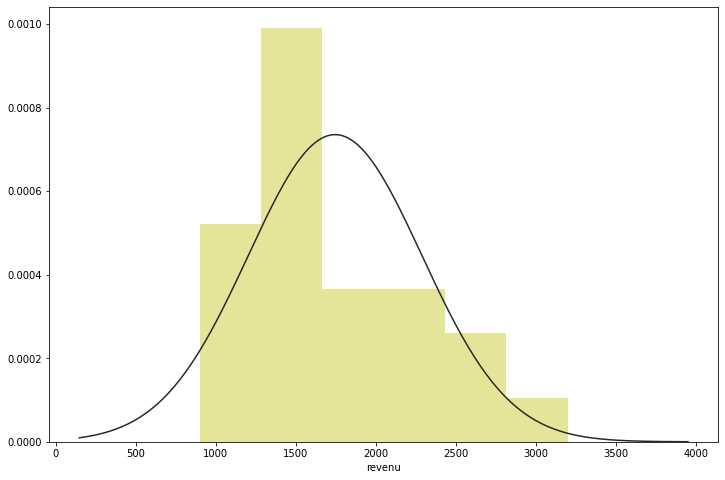

In [51]:
plt.figure(figsize=(12,8))
chart = sns.distplot(project_data["revenu"], fit=norm, kde=False, color='y')

<AxesSubplot:>

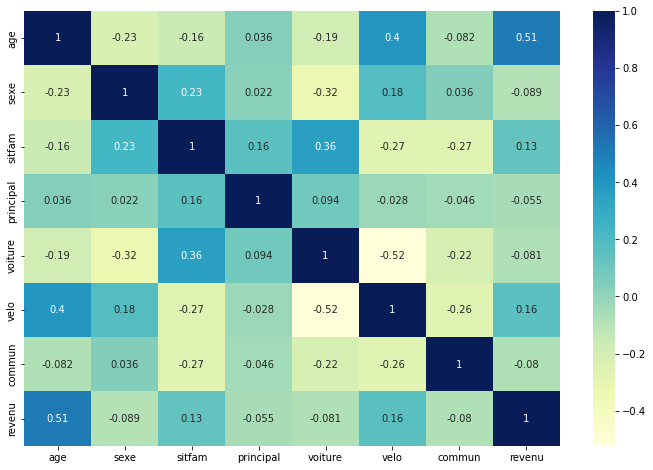

In [52]:
plt.figure(figsize=(12,8))
data_new = project_data.drop(columns=["num"])
corr = data_new.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")

## Data Preparation and Model Creation

In [53]:
X_train=project_data.drop(columns=["commun","num"])
y_train=project_data["commun"]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('Feature Training set shape: ',X_train.shape)
print('Target Training set shape: ',y_train.shape)

Feature Training set shape:  (40, 7)
Target Training set shape:  (40,)


In [54]:
numeric_columns = X_train.select_dtypes(exclude='object').columns
print(numeric_columns)
print('*'*100)
categorical_columns = X_train.select_dtypes(include='object').columns
print(categorical_columns)

Index(['age', 'sexe', 'sitfam', 'principal', 'voiture', 'velo', 'revenu'], dtype='object')
****************************************************************************************************
Index([], dtype='object')


In [55]:
numeric_features = Pipeline([
    ('handlingmissingvalues',SimpleImputer(strategy='median')),
    ('scaling',StandardScaler(with_mean=True))
])

print(numeric_features)
print('*'*100)

categorical_features = Pipeline([
    ('handlingmissingvalues',SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder()),
    ('scaling', StandardScaler(with_mean=False))
])

print(categorical_features)

processing = ColumnTransformer([
    ('numeric', numeric_features, numeric_columns),
    ('categorical', categorical_features, categorical_columns)
])

processing

Pipeline(steps=[('handlingmissingvalues', SimpleImputer(strategy='median')),
                ('scaling', StandardScaler())])
****************************************************************************************************
Pipeline(steps=[('handlingmissingvalues',
                 SimpleImputer(strategy='most_frequent')),
                ('encoding', OneHotEncoder()),
                ('scaling', StandardScaler(with_mean=False))])


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('handlingmissingvalues',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 Index(['age', 'sexe', 'sitfam', 'principal', 'voiture', 'velo', 'revenu'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('handlingmissingvalues',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding', OneHotEncoder()),
                                                 ('scaling',
                                                  StandardScaler(with_mean=False))]),
                                 Index([], dtype='object'))])

In [56]:
def prepare_model(algorithm):
    model = Pipeline(steps= [
        ('processing',processing),
        ('pca', TruncatedSVD(n_components=3, random_state=12)),
        ('modeling', algorithm)
    ])
    model.fit(X_train, y_train)
    return model

In [57]:
def prepare_confusion_matrix(algo, model):
    print(algo)
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    plt.show()
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

In [58]:
def prepare_classification_report(algo, model):
    print(algo+' Report :')
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))

In [59]:
def prepare_roc_curve(algo, model):
    print(algo)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    roc_auc = auc(fpr, tpr)
    curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    curve.plot()
    plt.show()

In [60]:
algorithms = [('logistic regression', LogisticRegression()), 
              ('KNN classifier', KNeighborsClassifier()), 
              ('Random Forest calssifier', RandomForestClassifier()), 
              ('Adaboost classifier', AdaBoostClassifier()), 
              ('Gradientboot classifier',GradientBoostingClassifier()),
              ('Naive-bayes Classifier', GaussianNB()),
              ('Support Vector Classifier', SVC(probability=True))
             ]

trained_models = []
model_and_score = {}

for index, tup in enumerate(algorithms):
    model = prepare_model(tup[1])
    model_and_score[tup[0]] = str(model.score(X_train,y_train)*100)+"%"
    trained_models.append((tup[0],model))

## Model Evaluation

In [61]:
#vistazo al rendimiento del modelo. Para hacer esto, voy a usar el coeficiente de determinación. 
#Cuanto más se acerque este valor a 1, mejor será el modelo.
print(model_and_score)

{'logistic regression': '57.49999999999999%', 'KNN classifier': '65.0%', 'Random Forest calssifier': '100.0%', 'Adaboost classifier': '100.0%', 'Gradientboot classifier': '100.0%', 'Naive-bayes Classifier': '67.5%', 'Support Vector Classifier': '70.0%'}


logistic regression


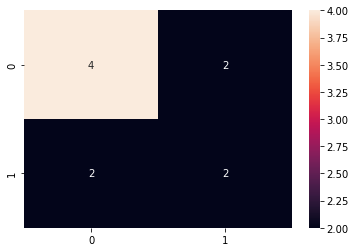

KNN classifier


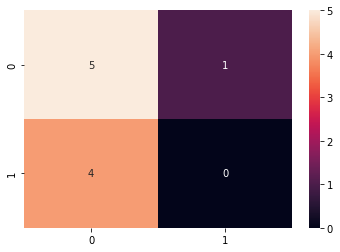

Random Forest calssifier


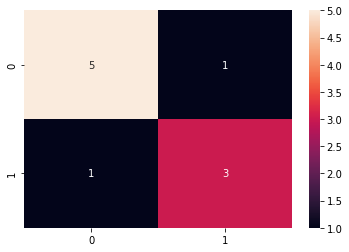

Adaboost classifier


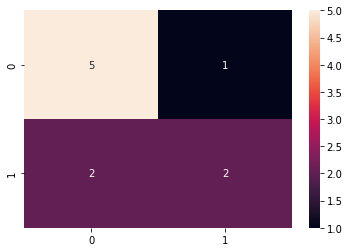

Gradientboot classifier


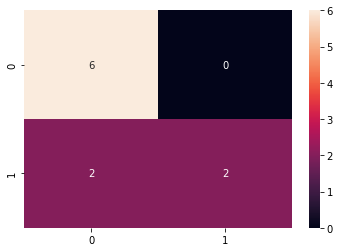

Naive-bayes Classifier


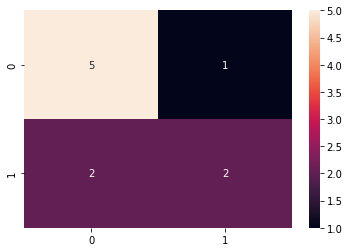

Support Vector Classifier


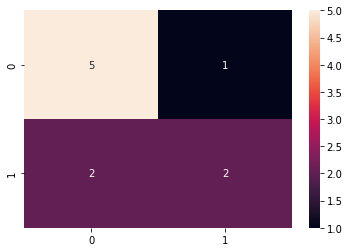

In [62]:
for index, tup in enumerate(trained_models):
    prepare_confusion_matrix(tup[0], tup[1])

In [63]:
for index, tup in enumerate(trained_models):
    prepare_classification_report(tup[0], tup[1])
    print("\n")

logistic regression Report :
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.50      0.50      0.50         4

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10



KNN classifier Report :
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67         6
         1.0       0.00      0.00      0.00         4

    accuracy                           0.50        10
   macro avg       0.28      0.42      0.33        10
weighted avg       0.33      0.50      0.40        10



Random Forest calssifier Report :
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79    

logistic regression


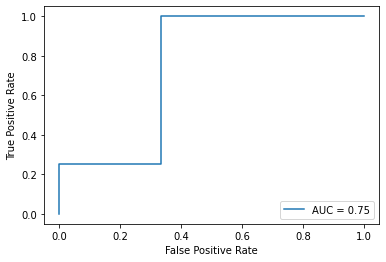

KNN classifier


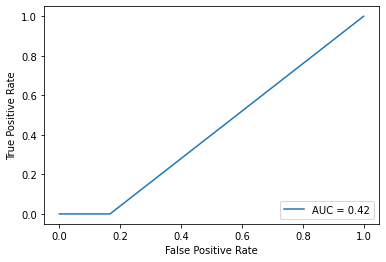

Random Forest calssifier


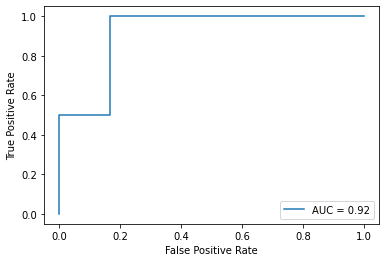

Adaboost classifier


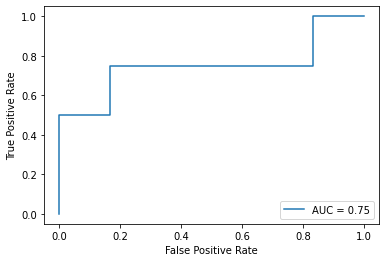

Gradientboot classifier


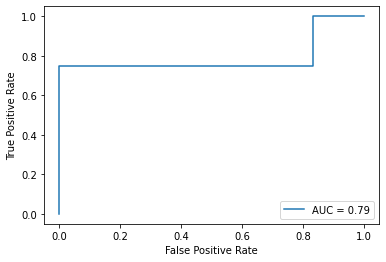

Naive-bayes Classifier


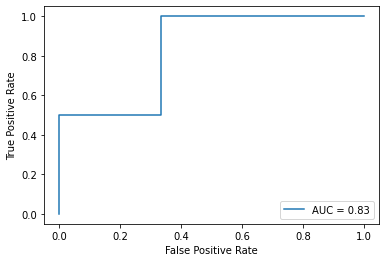

Support Vector Classifier


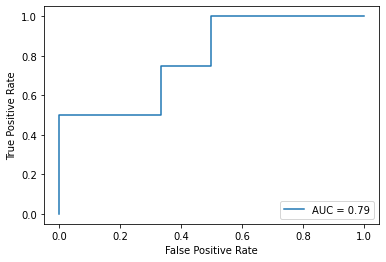

In [64]:
for index, tup in enumerate(trained_models):
    prepare_roc_curve(tup[0], tup[1])